In [40]:
%matplotlib  inline
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.color import rgb2gray
import os
import skimage.feature
import skimage.filters
import skimage.color
from skimage.util import invert
from skimage.morphology import skeletonize
from scipy.signal import correlate2d
import pandas as pd
# import cv2
from pathlib import Path
from joblib import Parallel, delayed
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib
from sklearn import model_selection
import logging
from sklearn.metrics import confusion_matrix
import seaborn as sns
from glob import glob
import shutil
from ast import literal_eval
from skimage.feature import blob_dog, blob_log, blob_doh

## Pipelines for Processing Images and Label Text Files

The pipeline starts with a directory and goes through and generates a pandas dataframe of segmented image filenames based on the label text file associated with each image.

In [41]:
def rf_label_reader(txt_file, image_file):
    """Reads in text file and associated image file and using the information in the text file
    makes an array of labels and saves the associated region of the image corrsponding to that label
    to create training and testing data for random forest creation"""
    txt_info = open(txt_file,'r')
    image = io.imread(image_file, as_grey=True)
    #test for 1024x1024 image
    if image.shape != (1024,1024):
        raise RuntimeError('Image is not required shape: 1024x1024')
    
    #setup required variables
    txt = []
    centers = []
    radii = []
    labels = []
    image_cuts = []
    empty_count = 0 #how many image cuts generated with the label empty meaning no particle present
    null_count = 0 #how many image cuts generated with the label null meaning particle present but not atomic resolution
    no_count = 0 #how many image cuts generated with the label no meaning particle present, atomic res, no defect
    yes_count = 0 #how many image cuts generated with the label yes meaning particle present, atomic res, has defect
    
    #read text file
    for line in txt_info:
        if line == '\n':
            pass
        else:
            line = line.strip('\n')
            txt.append(line)
    center_stop = txt.index('Radius Size:')
    radius_stop = txt.index('Defect Label:')
    label_stop = txt.index('Image Size:')
    
    #create image and label pair
    if radius_stop - center_stop == 1: #ID if there are no particles present in text file
        for x in range(0,4*256,256):
            for y in range(0,4*256,256):
                image_slice = image[x:x+256,y:y+256]
                image_cuts.append(image_slice)
                labels.append('empty')
                empty_count += 1
    else:
        for loc in txt[1:center_stop]:
            centers.append(literal_eval(loc))
        for loc in txt[center_stop+1:radius_stop] :
            radii.append(int(loc))
        for loc in txt[radius_stop+1:label_stop] :
            labels.append(loc)
            if loc == 'null':
                null_count += 1
            if loc == 'no':
                no_count += 1
            if loc == 'yes':
                yes_count += 1
        for idx, center in enumerate(centers): #slice up image to create images to feed into 
            x_min = center[0]-radii[idx]-2
            x_max = center[0]+radii[idx]+2
            y_min = center[1]-radii[idx]-2
            y_max = center[1]+radii[idx]+2
            if x_min < 0:
                x_min = 0
            if y_min < 0:
                y_min = 0
            if x_max > 1023:
                x_max = 1023
            if y_max > 1023:
                y_max = 1023
            image_slice = image[int(y_min):int(y_max), int(x_min):int(x_max)]
            image_cuts.append(image_slice)

    return labels, image_cuts, empty_count, null_count, no_count, yes_count

In [1]:
def rotate(df):
    """Function to rotate non-null images in order to augment data"""
    rot_dir = {'filename':[],'label':[]}
    for idx, label in enumerate(df['label']):
        if label == 'null':
            pass
        else:
            image = io.imread(df['filename'][idx])
            name = df['filename'][idx].split('.')[0]
            for count in np.arange(1,4):
                rot_img = np.rot90(image,count)
                rot_dir['filename'].append(name+'rot'+str(count)+'.png')
                rot_dir['label'].append(label)
                try:
                    plt.imsave(name+'rot'+str(count)+'.png',rot_img,cmap = 'gray')
                except: 
                    pass
    df2 = pd.DataFrame(data = rot_dir)
    df = df.append(df2)
    print('Done!')
    return df

In [43]:
def rf_data_pipeline(directory):
    """Wrapper function to run through directories of labels and images to create random forest
    training and testing set. Returns a pandas dataframe with all the labels and associated image file names"""
    #set up required variables
    if os.path.isdir(directory+'/text_files') == False:
        raise RuntimeError('No text file directory present.')
    if os.path.isdir(directory+'/images') == False:
        raise RuntimeError('No image file directory present.')
    txt_list = glob(directory+'/text_files/*.txt')
    image_list = glob(directory+'/images/*.png')
    if len(txt_list) == 0:
        raise RuntimeError('No txt label files')
    if len(image_list) == 0:
        raise RuntimeError('No image files')
    txt_name_list = [name.split('/')[-1].split('.')[0] for name in txt_list]
    image_name_list = [name.split('/')[-1].split('.')[0] for name in image_list]
    data = {'filename':[],'label':[]}
    total_empty_count = 0
    total_null_count = 0
    total_no_count = 0
    total_yes_count = 0
    if os.path.isdir(directory+'/old_text_files') == False:
        os.mkdir(directory+'/old_text_files')
    if os.path.isdir(directory+'/old_images') == False:
        os.mkdir(directory+'/old_images')
    if os.path.isdir(directory+'/labeled_images') == False:
        os.mkdir(directory+'/labeled_images')

    #test for correct images and labels
    if txt_name_list != image_name_list:
        raise RuntimeError('Names of txt label files do not match names of image files.')
    
    #create dataframe of files and labels
    for idx, txt in enumerate(txt_list):
        labels, image_cuts, empty_count, null_count, no_count, yes_count = rf_label_reader(txt, image_list[idx])
        total_empty_count += empty_count
        total_null_count += null_count
        total_no_count += no_count
        total_yes_count += yes_count
        for idx2, label in enumerate(labels):
            data['label'].append(label)
            rf_data_fname = directory+'/labeled_images/'+image_name_list[idx]+ '_'+ label + '_' + str(idx2) +'.png'
            plt.imsave(rf_data_fname,image_cuts[idx2], cmap='gray')
            data['filename'].append(rf_data_fname)
        shutil.move(txt,directory+'/old_text_files/')
        shutil.move(image_list[idx],directory+'/old_images/')
    df = pd.DataFrame(data = data)
    print(df['label'].iloc[0])
    df = rotate(df)
    df.to_csv(directory+'/rf_data.csv')
    print('done!')
    print('empty: {}, null: {}, no: {}, yes {}'.format(total_empty_count*4, total_null_count,total_no_count*4,total_yes_count*4))
    return df, (total_empty_count, total_null_count, total_no_count, total_yes_count)

In [45]:
directory = os.getcwd()

In [23]:
df = rf_data_pipeline(directory)

null
Done!
done!
empty: 576, null: 871, no: 552, yes 852


In [47]:
df = pd.read_csv(directory+'/rf_data/rf_data.csv')

In [54]:
df = df.fillna('null')

In [55]:
df.head()

,Unnamed: 0,filename,label
0,0,/Users/cgroschner/Documents/pythonLearn/grosch...,null
1,1,/Users/cgroschner/Documents/pythonLearn/grosch...,yes
2,2,/Users/cgroschner/Documents/pythonLearn/grosch...,null
3,3,/Users/cgroschner/Documents/pythonLearn/grosch...,null
4,4,/Users/cgroschner/Documents/pythonLearn/grosch...,null


## Making Features

Here I show all the code for different features which will be fed into the random forest classifier.

In [56]:
def sobel_edges(gray_image):
    """Returns histogram of edges"""
    edges = skimage.filters.sobel(gray_image)
    edge_hist = np.histogram(edges.flatten(),bins=50, density = True)[0]
    return edge_hist

def blobs_log(gray_image):
    """returns two features: average blob size and total number of blobs detected by laplace of gaussians"""
    blob = skimage.feature.blob_log(gray_image,max_sigma=2, num_sigma=30, threshold=.2)
    blobs = blob[:,2]
    num_blobs = len(blobs)
    if num_blobs == 0:
        avg_blob = 0
    else:
        avg_blob = blobs.mean()
    blob_info = np.array([avg_blob, num_blobs])
    return blob_info

def fft_hist(gray_image):
    """returns 20 bin histogram of frequencies from fft of image"""
    fft = np.log2(abs(np.fft.rfft2(gray_image)))
    fhist = np.histogram(fft,bins=20,density = True)[0]
    return fhist

def center_cut(image):
    """returns a 1d array of length 400 which is 20x20 center of the image"""
    middle = (image.shape[0]//2,image.shape[1]//2)
    cut = image[(middle[0]-10):(middle[0]+10),(middle[1]-10):(middle[1]+10)].ravel()
    return cut

def lbp_cut(gray_image):
    """returns a 1d array of length 400 which is 20x20 center of the lbp"""
    lbp = skimage.feature.local_binary_pattern(gray_image,2,16)
    middle = (lbp.shape[0]//2,lbp.shape[1]//2)
    lbp = lbp[(middle[0]-10):(middle[0]+10),(middle[1]-10):(middle[1]+10)].ravel()
    return lbp

def gray_range(image):
    """gives the mean and standard deviation for the image"""
    irange = np.array([image.mean(),image.std()])
    return irange

def get_features(file, label):
    """Function takes in a file name from list of files, opens it, creates a gray version for features which require
    gray image and then creates a list of features as well as a label which is then returned"""
    image = io.imread(file, as_grey=True)
    features = []
    features.append(center_cut(image))
    features.append(lbp_cut(image))
    features.append(fft_hist(image))
    features.append(blobs_log(image))
    features.append(sobel_edges(image))
    features.append(gray_range(image))
    features = np.concatenate(features) 
    return (features,label)

## Here I just wanted to see what some of these image processing methods do with my data

In [21]:
blobs = blobs_dog(test)

array([ 3.54589795, 62.        ])

/Users/cgroschner/Documents/pythonDev/particleRecognition/classfier_builds/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


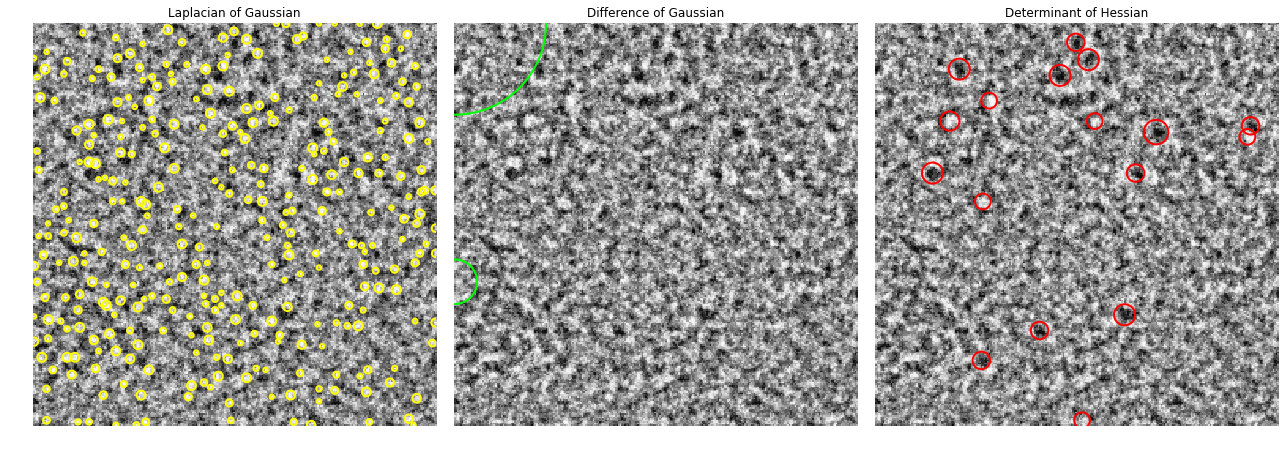

In [56]:

blobs_log  = blob_log(test2,max_sigma=2, num_sigma=30, threshold=.2)

# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2)

blobs_dog = blob_dog(test2, min_sigma=10, max_sigma=50, threshold=.2)
blobs_dog[:, 2] = blobs_dog[:, 2] * np.sqrt(2)

blobs_doh = blob_doh(test2,min_sigma=5, max_sigma=10, threshold=.01)

blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
          'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 3, figsize=(18, 9), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(test2, interpolation='nearest',cmap="Greys_r")
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()

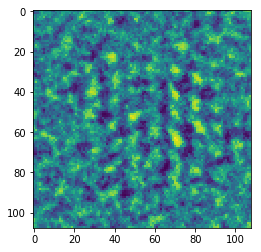

In [25]:
test2 = io.imread('/Users/cgroschner/Documents/pythonDev/particleRecognition/classfier_builds/rf_data/labeled_images/101729F_plasma15sec_Mh370kx__0055_yes_0.png',as_grey=True)
plt.imshow(test2)

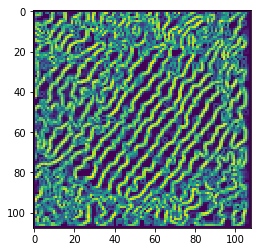

/Users/cgroschner/Documents/pythonDev/particleRecognition/classfier_builds/venv/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [127]:
plt.imshow(skimage.filters.sobel(skimage.feature.local_binary_pattern(test,n_points,radius)))

## Pipeline for Processing Feature Data

In [61]:
def feature_frame(file_label_df):
    """Creates a pandas dataframe with all the calculated features for all the images in a given dataframe which
    contains all the images file names and labels."""
    features = [get_features(file, file_label_df['label'].iloc[idx]) for idx,file in enumerate(file_label_df['filename'])]
    print('Done!')
    feat_list, labels_list = zip(*features)
    df = pd.DataFrame.from_records(feat_list)
    column_names = [['center_cut']*400,['lbp_cut']*400,\
                    ['fft_hist']*20,['blobs_log']*2,['sobel_edges']*50,['mean'],['std']]
    column_names = sum(column_names, [])
    df.columns = column_names
    df['Label'] = labels_list
    return df

In [60]:
features

,center_cut,center_cut,center_cut,center_cut,center_cut,center_cut,center_cut,center_cut,center_cut,center_cut,...,sobel_edges,sobel_edges,sobel_edges,sobel_edges,sobel_edges,sobel_edges,sobel_edges,mean,std,Label
0,0.701961,0.717647,0.564706,0.466667,0.368627,0.250980,0.141176,0.082353,0.050980,0.098039,...,0.035497,0.070994,0.008874,0.017749,0.026623,0.000000,0.008874,0.447478,0.192518,null
1,0.486275,0.694118,0.541176,0.541176,0.658824,0.886275,0.862745,0.525490,0.349020,0.592157,...,0.016487,0.008244,0.008244,0.024731,0.008244,0.000000,0.008244,0.449941,0.190117,yes
2,0.823529,0.788235,0.733333,0.525490,0.411765,0.411765,0.254902,0.200000,0.301961,0.200000,...,0.052451,0.017484,0.008742,0.008742,0.000000,0.008742,0.043709,0.474684,0.193109,null
3,0.219608,0.243137,0.368627,0.368627,0.474510,0.443137,0.584314,0.603922,0.619608,0.494118,...,0.047015,0.028209,0.028209,0.047015,0.018806,0.000000,0.028209,0.449085,0.188382,null
4,0.541176,0.552941,0.345098,0.411765,0.400000,0.329412,0.188235,0.450980,0.729412,0.541176,...,0.072502,0.027188,0.036251,0.036251,0.018125,0.009063,0.018125,0.467900,0.190216,null
5,0.858824,0.913725,0.913725,0.874510,0.819608,0.596078,0.584314,0.388235,0.301961,0.443137,...,0.017409,0.026114,0.043523,0.017409,0.008705,0.000000,0.008705,0.451664,0.185779,yes
6,0.368627,0.317647,0.576471,0.450980,0.368627,0.392157,0.588235,0.521569,0.647059,0.588235,...,0.032532,0.026025,0.013013,0.006506,0.013013,0.000000,0.006506,0.465061,0.186706,null
7,0.137255,0.070588,0.156863,0.325490,0.360784,0.549020,0.886275,0.901961,0.937255,0.972549,...,0.018760,0.056279,0.028139,0.037519,0.028139,0.009380,0.018760,0.460285,0.187844,null
8,0.313725,0.419608,0.380392,0.454902,0.494118,0.521569,0.454902,0.486275,0.282353,0.294118,...,0.094974,0.051140,0.058446,0.014611,0.014611,0.014611,0.029223,0.442471,0.175597,null
9,0.309804,0.411765,0.274510,0.301961,0.172549,0.180392,0.286275,0.301961,0.376471,0.454902,...,0.000000,0.000000,0.016707,0.000000,0.000000,0.000000,0.008354,0.316707,0.125946,null


/Users/cgroschner/Documents/pythonDev/particleRecognition/classfier_builds/venv/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [61]:
features.to_csv(directory+'/rf_features.csv')

/Users/cgroschner/Documents/pythonDev/particleRecognition/classfier_builds/venv/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [63]:
features = pd.read_csv(directory+'/rf_data/rf_features.csv')

In [80]:
features = features.fillna('null')

In [81]:
features.head()

,Unnamed: 0,center_cut,center_cut.1,center_cut.2,center_cut.3,center_cut.4,center_cut.5,center_cut.6,center_cut.7,center_cut.8,...,sobel_edges.43,sobel_edges.44,sobel_edges.45,sobel_edges.46,sobel_edges.47,sobel_edges.48,sobel_edges.49,mean,std,Label
0,0,0.701961,0.717647,0.564706,0.466667,0.368627,0.250980,0.141176,0.082353,0.050980,...,0.035497,0.070994,0.008874,0.017749,0.026623,0.000000,0.008874,0.447478,0.192518,null
1,1,0.486275,0.694118,0.541176,0.541176,0.658824,0.886275,0.862745,0.525490,0.349020,...,0.016487,0.008244,0.008244,0.024731,0.008244,0.000000,0.008244,0.449941,0.190117,yes
2,2,0.823529,0.788235,0.733333,0.525490,0.411765,0.411765,0.254902,0.200000,0.301961,...,0.052451,0.017484,0.008742,0.008742,0.000000,0.008742,0.043709,0.474684,0.193109,null
3,3,0.219608,0.243137,0.368627,0.368627,0.474510,0.443137,0.584314,0.603922,0.619608,...,0.047015,0.028209,0.028209,0.047015,0.018806,0.000000,0.028209,0.449085,0.188382,null
4,4,0.541176,0.552941,0.345098,0.411765,0.400000,0.329412,0.188235,0.450980,0.729412,...,0.072502,0.027188,0.036251,0.036251,0.018125,0.009063,0.018125,0.467900,0.190216,null


In [82]:
def balance_data_classes(df,total_empty_count, total_null_count, total_no_count, total_yes_count):
    """Create two balanced dataframes of features with an equal number of each class, one with 80% of the data
    the other with 20% of the data"""
    cutoff = int(np.array([total_empty_count, total_null_count, total_no_count, total_yes_count]).min()*0.8)
    #shuffle input dataframe so that you do not end up with the same rotated image several times
    df = shuffle(df, random_state=0)
    bal_df1 = pd.DataFrame(columns=df.columns.values)
    bal_df2 = pd.DataFrame(columns=df.columns.values)
    names_list = df['Label'].drop_duplicates()
    for name in names_list:
        temp = df[df.values == name]
        bal_df1=bal_df1.append(temp.iloc[:cutoff,:])
        bal_df2=bal_df2.append(temp.iloc[cutoff:,:])
    bal_df1 = shuffle(bal_df1, random_state=0)
    bal_df2 = shuffle(bal_df2, random_state=0)
    return bal_df1, bal_df2

In [83]:
train_features, test_features = balance_data_classes(features,576,871,552,852)

In [84]:
train_features

,Unnamed: 0,center_cut,center_cut.1,center_cut.2,center_cut.3,center_cut.4,center_cut.5,center_cut.6,center_cut.7,center_cut.8,...,sobel_edges.43,sobel_edges.44,sobel_edges.45,sobel_edges.46,sobel_edges.47,sobel_edges.48,sobel_edges.49,mean,std,Label
2133,2133,0.380392,0.235294,0.337255,0.435294,0.635294,0.607843,0.450980,0.474510,0.800000,...,0.052386,0.019645,0.032741,0.032741,0.006548,0.013096,0.006548,0.472853,0.178130,no
59,59,0.486275,0.333333,0.250980,0.184314,0.141176,0.152941,0.152941,0.368627,0.219608,...,0.124328,0.062164,0.087030,0.037299,0.024866,0.024866,0.012433,0.440929,0.196120,yes
718,718,0.141176,0.235294,0.231373,0.270588,0.235294,0.286275,0.360784,0.329412,0.360784,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007845,0.283912,0.119197,null
2722,2722,0.325490,0.588235,0.513725,0.466667,0.474510,0.274510,0.031373,0.152941,0.600000,...,0.066765,0.053412,0.026706,0.033383,0.020030,0.000000,0.013353,0.447395,0.183068,yes
1182,1182,0.396078,0.458824,0.509804,0.549020,0.533333,0.737255,0.458824,0.215686,0.137255,...,0.022604,0.016953,0.000000,0.000000,0.000000,0.000000,0.011302,0.470219,0.179721,no
1675,1675,0.407843,0.494118,0.815686,0.592157,0.537255,0.407843,0.427451,0.462745,0.427451,...,0.030841,0.006493,0.011363,0.003246,0.009739,0.001623,0.004870,0.421218,0.169215,empty
1282,1282,0.682353,0.576471,0.639216,0.843137,0.925490,0.850980,0.870588,0.745098,0.501961,...,0.036886,0.061477,0.036886,0.024591,0.036886,0.024591,0.036886,0.457439,0.187077,no
2132,2132,0.450980,0.450980,0.270588,0.435294,0.721569,0.250980,0.294118,0.698039,0.564706,...,0.052386,0.019645,0.032741,0.032741,0.006548,0.013096,0.006548,0.472853,0.178130,no
1787,1787,0.592157,0.462745,0.556863,0.372549,0.301961,0.235294,0.235294,0.356863,0.474510,...,0.013680,0.007600,0.001520,0.004560,0.001520,0.003040,0.001520,0.442527,0.176820,empty
1891,1891,0.380392,0.349020,0.509804,0.564706,0.737255,0.537255,0.509804,0.329412,0.435294,...,0.007794,0.003118,0.000000,0.000000,0.000000,0.000000,0.001559,0.457338,0.164397,empty


In [85]:
test_features

,Unnamed: 0,center_cut,center_cut.1,center_cut.2,center_cut.3,center_cut.4,center_cut.5,center_cut.6,center_cut.7,center_cut.8,...,sobel_edges.43,sobel_edges.44,sobel_edges.45,sobel_edges.46,sobel_edges.47,sobel_edges.48,sobel_edges.49,mean,std,Label
2003,2003,0.470588,0.254902,0.254902,0.227451,0.149020,0.262745,0.380392,0.403922,0.560784,...,0.066340,0.037909,0.018954,0.009477,0.037909,0.018954,0.009477,0.311694,0.133793,yes
2446,2446,0.584314,0.658824,0.658824,0.745098,0.505882,0.309804,0.470588,0.309804,0.156863,...,0.028967,0.000000,0.009656,0.000000,0.009656,0.000000,0.009656,0.453440,0.187767,no
1551,1551,0.552941,0.749020,0.729412,0.764706,0.552941,0.490196,0.470588,0.490196,0.278431,...,0.164184,0.082092,0.041046,0.030785,0.030785,0.030785,0.030785,0.444602,0.193642,yes
594,594,0.552941,0.243137,0.364706,0.396078,0.494118,0.443137,0.513725,0.741176,0.741176,...,0.011658,0.000000,0.000000,0.011658,0.017487,0.000000,0.005829,0.411771,0.154677,null
2405,2405,0.596078,0.462745,0.596078,0.376471,0.376471,0.494118,0.552941,0.537255,0.513725,...,0.031205,0.012482,0.024964,0.006241,0.000000,0.000000,0.006241,0.451456,0.188174,no
1584,1584,0.078431,0.184314,0.243137,0.282353,0.313725,0.403922,0.372549,0.282353,0.184314,...,0.037848,0.018924,0.018924,0.003154,0.006308,0.009462,0.006308,0.409343,0.171415,yes
2642,2642,0.474510,0.341176,0.368627,0.529412,0.423529,0.368627,0.686275,0.474510,0.619608,...,0.044650,0.033487,0.011162,0.011162,0.000000,0.000000,0.022325,0.454713,0.192521,yes
677,677,0.698039,0.392157,0.537255,0.639216,0.866667,0.898039,0.843137,0.737255,0.368627,...,0.000000,0.036624,0.007325,0.014650,0.000000,0.000000,0.007325,0.452289,0.177965,null
741,741,0.266667,0.486275,0.701961,0.560784,0.407843,0.313725,0.341176,0.658824,0.560784,...,0.012126,0.007579,0.004547,0.009094,0.001516,0.000000,0.001516,0.439357,0.150374,empty
2344,2344,0.576471,0.576471,0.615686,0.658824,0.533333,0.533333,0.658824,0.760784,0.760784,...,0.019628,0.028039,0.022431,0.014020,0.000000,0.005608,0.002804,0.461321,0.170358,no


In [86]:
def split_set(train_set,test_set):
    """splits training and testing dataframes into feature and label sets"""
    X_train = train_set.iloc[:,:-1]
    Y_train = train_set.iloc[:,-1]
    X_test = test_set.iloc[:,:-1]
    Y_test = test_set.iloc[:,-1]
    return X_train, Y_train, X_test, Y_test

In [87]:
X_train, Y_train, X_test, Y_test = split_set(train_features,test_features)

In [88]:
X_test

,Unnamed: 0,center_cut,center_cut.1,center_cut.2,center_cut.3,center_cut.4,center_cut.5,center_cut.6,center_cut.7,center_cut.8,...,sobel_edges.42,sobel_edges.43,sobel_edges.44,sobel_edges.45,sobel_edges.46,sobel_edges.47,sobel_edges.48,sobel_edges.49,mean,std
2003,2003,0.470588,0.254902,0.254902,0.227451,0.149020,0.262745,0.380392,0.403922,0.560784,...,0.056863,0.066340,0.037909,0.018954,0.009477,0.037909,0.018954,0.009477,0.311694,0.133793
2446,2446,0.584314,0.658824,0.658824,0.745098,0.505882,0.309804,0.470588,0.309804,0.156863,...,0.038623,0.028967,0.000000,0.009656,0.000000,0.009656,0.000000,0.009656,0.453440,0.187767
1551,1551,0.552941,0.749020,0.729412,0.764706,0.552941,0.490196,0.470588,0.490196,0.278431,...,0.071831,0.164184,0.082092,0.041046,0.030785,0.030785,0.030785,0.030785,0.444602,0.193642
594,594,0.552941,0.243137,0.364706,0.396078,0.494118,0.443137,0.513725,0.741176,0.741176,...,0.029145,0.011658,0.000000,0.000000,0.011658,0.017487,0.000000,0.005829,0.411771,0.154677
2405,2405,0.596078,0.462745,0.596078,0.376471,0.376471,0.494118,0.552941,0.537255,0.513725,...,0.056170,0.031205,0.012482,0.024964,0.006241,0.000000,0.000000,0.006241,0.451456,0.188174
1584,1584,0.078431,0.184314,0.243137,0.282353,0.313725,0.403922,0.372549,0.282353,0.184314,...,0.053618,0.037848,0.018924,0.018924,0.003154,0.006308,0.009462,0.006308,0.409343,0.171415
2642,2642,0.474510,0.341176,0.368627,0.529412,0.423529,0.368627,0.686275,0.474510,0.619608,...,0.066975,0.044650,0.033487,0.011162,0.011162,0.000000,0.000000,0.022325,0.454713,0.192521
677,677,0.698039,0.392157,0.537255,0.639216,0.866667,0.898039,0.843137,0.737255,0.368627,...,0.007325,0.000000,0.036624,0.007325,0.014650,0.000000,0.000000,0.007325,0.452289,0.177965
741,741,0.266667,0.486275,0.701961,0.560784,0.407843,0.313725,0.341176,0.658824,0.560784,...,0.016673,0.012126,0.007579,0.004547,0.009094,0.001516,0.000000,0.001516,0.439357,0.150374
2344,2344,0.576471,0.576471,0.615686,0.658824,0.533333,0.533333,0.658824,0.760784,0.760784,...,0.039255,0.019628,0.028039,0.022431,0.014020,0.000000,0.005608,0.002804,0.461321,0.170358


## Training and Testing Random Forest

In [89]:
def train_random_forest(X_train, Y_train, nestimators = 50,crit='gini',max_feat='auto'):
    """function that takes in the training feature set and training labels and trains a radnom forest with 
    n estimators given by nestimators"""
    classifier = RandomForestClassifier(n_estimators= nestimators,criterion= crit,max_features=max_feat)
    classifier.fit(X_train, Y_train)
    return classifier

In [90]:
model = train_random_forest(X_train,Y_train)

In [91]:
def cross_val_stratified(features_df,model,nsplit):
    """runs stratified k-fold cross validation where nsplit specifies the number of splits
    and returns the mean and standard deviation of the cross validation score. Based on the code shown in 
    class."""
    X = features_df.iloc[:,:-1]
    Y = features_df.iloc[:,-1]
    cv = StratifiedKFold(n_splits=nsplit)
    scores = cross_val_score(model, X, Y, cv=cv, n_jobs=-1)
    print("mean: {:3f}, stdev: {:3f}".format(
        np.mean(scores), np.std(scores)))

In [92]:
cross_val_stratified(train_features,model,5)

mean: 0.761325, stdev: 0.011486


In [93]:
def plot_confusion_matrix(X, Y, df, model):
    """Creates a confusion matrix for the different classes given a set of features, true labels, the dataset
    and the desired trained classfier"""
    Y_pred = model.predict(X)
    Y_labels = df['Label'].drop_duplicates()
    cfm = confusion_matrix(Y, Y_pred, labels=Y_labels)
    df_cfm = pd.DataFrame(data = cfm, columns=Y_labels, index=Y_labels)
    plt.subplots(figsize=(5,5))
    ax = sns.heatmap(df_cfm, vmax = 90, annot=True, fmt="d",cmap='rainbow')

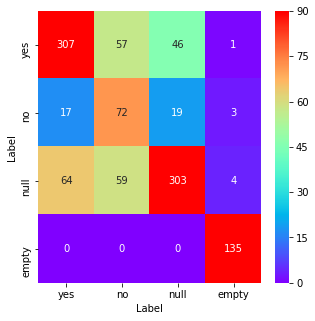

In [94]:
plot_confusion_matrix(X_test,Y_test,test_features,model)

In [128]:
def feature_importance(X_train,classifier):
    """Makes a plot of feature importance based of the feature importances calculated by scikit learn.
    Obviously features such as historgrams actually go into the classifier as several features so the function
    adds the importances of each of the features belonging to a certain class of feature"""
    feat_importance = np.vstack((X_train.columns.values[1:],classifier.feature_importances_[1:]))
    previous = feat_importance[0,0]
    classes = [previous]
    counts = []
    temp_count = 0
    for idx, classify in enumerate(feat_importance[0,:]):
        if classify.split('.')[0] == previous:
            temp_count += feat_importance[1,idx]
            previous = classify.split('.')[0]
        else:
            counts.append(temp_count)
            classes.append(classify)
            temp_count = 0
            temp_count += feat_importance[1,idx]
            previous = classify

    counts.append(temp_count)
    fig, ax = plt.subplots()
    plt.bar(np.arange(1,len(classes)+1),counts,tick_label = classes)
    for tick in ax.get_xticklabels():
        tick.set_rotation(80)
    ax.set_xlabel('Feature Class')
    ax.set_ylabel('Feature Importance')
    ax.set_title("Feature Importance vs Feature Class")

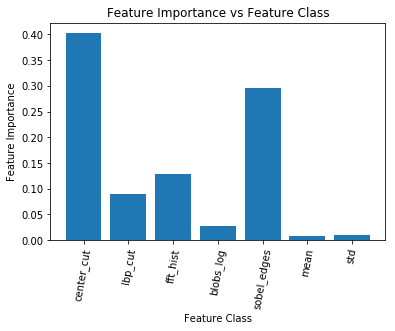

In [129]:
feature_importance(X_train,model)

In [100]:
def optimize_model(X_train,Y_train, nestimators = [10,20,30,50,70,100]):
    """function which runs model optimization given a certain number of n_estimators, max_features, and criterion
    (gini or entropy)"""
    logging.basicConfig(level=logging.INFO,
                        format='%(asctime)s %(levelname)s %(message)s')
    parameters = {'n_estimators':nestimators,  'max_features':[3,8,10,'auto'], 
                 'criterion': ['gini','entropy']}
    rf_tune = model_selection.GridSearchCV(RandomForestClassifier(), parameters, 
                                       n_jobs = -1, cv = 5,verbose=1)
    rf_opt = rf_tune.fit(X_train, Y_train)
    print("Best zero-one score: " + str(rf_opt.best_score_) + "\n")
    print("Optimal Model:\n" + str(rf_opt.best_estimator_))
    return rf_opt

In [101]:
rf_opt = optimize_model(X_train,Y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   31.4s finished


Best zero-one score: 0.7953514739229025

Optimal Model:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


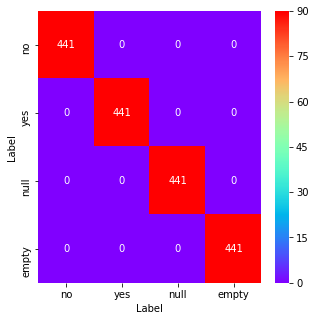

In [102]:
plot_confusion_matrix(X_train,Y_train,train_features,rf_opt)

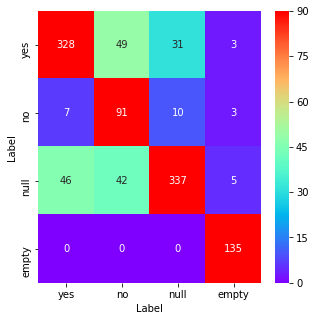

In [103]:
plot_confusion_matrix(X_test,Y_test,test_features,rf_opt)

In [131]:
opt_model = train_random_forest(X_train,Y_train,nestimators=100)

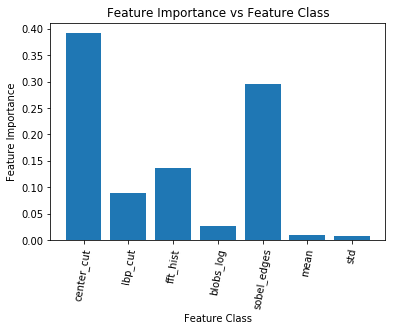

In [132]:
feature_importance(X_train,opt_model)

## The best news:

In [134]:
cross_val_stratified(test_features,opt_model,5)

mean: 0.802230, stdev: 0.020362


## It works!

In [135]:
#Saving model
directory = os.getcwd()
if os.path.isdir(directory+'/models') == False:
    os.mkdir(directory+'/models')
joblib.dump(opt_model,directory+'/models/'+'opt_random_forest.pkl')

['/Users/cgroschner/Documents/pythonLearn/groschner-python-ay250-homework/final_project/models/opt_random_forest.pkl']

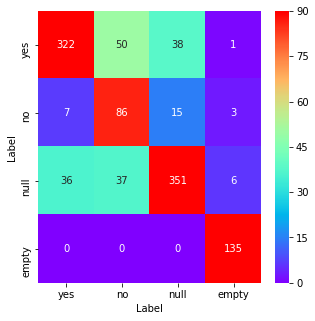

In [136]:
plot_confusion_matrix(X_test,Y_test,test_features,opt_model)

It works!!